In [1]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns

import math
import re

import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np

from datetime import date, timedelta
import plotly.offline as ply
import plotly.graph_objs as go
from plotly.tools import make_subplots
import plotly.express as px

ply.init_notebook_mode(connected=True)

from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import StandardScaler # used for feature scaling


import plotly.graph_objects as go
%matplotlib inline

In [2]:
#Загружаем данные
data = pd.read_csv("airbnb_prep.csv", header = 0, sep=';')

In [3]:
df = data.copy()

In [4]:
df.head()

,price,host_since,neighbourhood_cleansed,city,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,...,number_of_reviews,instant_bookable,calculated_host_listings_count,apartment,house,private_room,shared_room,strict_cancel,flexible_cancel,moderate_cancel
0,195.0,2632.0,1,1,4.0,1.0,1.0,1.0,1,0,...,2.0,1,21.770801,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,150.0,3201.0,1,1,2.0,1.5,1.0,1.0,1,14,...,2.0,1,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,140.0,4015.0,1,1,6.0,1.0,2.0,3.0,1,9,...,53.0,1,3.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,110.0,2745.0,1,1,3.0,1.0,0.0,2.0,1,12,...,32.0,1,4.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,119.0,3033.0,1,1,2.0,1.0,1.0,1.0,0,11,...,3.0,1,3.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0


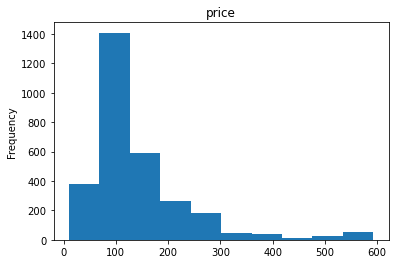

In [5]:
df['price'].plot(kind = 'hist', title='price')

В данной работе будет производится классификация квартир относительно цены. Как видно из графика, есть квартиры, основная масса квартир находится в диапазоне цен 0-400. Также есть небольшая доля квартир имеющих цены выше 400. Для этих объектов в новой переменной "класс" будет присвоино значение 1, что будет означать, что это квартиры из высокой ценовой категории. 

In [10]:
for i in range(df.shape[0]):
    if df.loc[i,'price'] >400:
        df.loc[i,'class'] =1
    else:
        df.loc[i,'class'] =0

In [13]:
len(df.columns)

25

In [18]:
# Splitting the dataset into the Training set and Test set
X = df.iloc[:, :24].values
y = df.iloc[:, -1].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler().fit(X_train)
X_train = sc_X.transform(X_train)
X_test = sc_X.transform(X_test)

## Logistic Regression

In [20]:
# Baseline model
import statsmodels.api as sm
lr = sm.Logit(y_train, X_train).fit()
print(lr.summary2())

Optimization terminated successfully.
         Current function value: 0.653739
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: -3.867   
Dependent Variable: y                AIC:              3199.0207
Date:               2020-11-05 11:09 BIC:              3337.9179
No. Observations:   2410             Log-Likelihood:   -1575.5  
Df Model:           23               LL-Null:          -323.69  
Df Residuals:       2386             LLR p-value:      1.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
x1         0.8782     0.0862   10.1851   0.0000    0.7092   1.0472
x2        -0.0152     0.0492   -0.3090   0.7573   -0.1117   0.0813
x3 

In [24]:
for i in range(len(df.columns)):
    print(i+1, df.columns[i])

1 price
2 host_since
3 neighbourhood_cleansed
4 city
5 accommodates
6 bathrooms
7 bedrooms
8 beds
9 bed_type
10 amenities
11 cleaning_fee
12 guests_included
13 minimum_nights
14 maximum_nights
15 number_of_reviews
16 instant_bookable
17 calculated_host_listings_count
18 apartment
19 house
20 private_room
21 shared_room
22 strict_cancel
23 flexible_cancel
24 moderate_cancel
25 class


Из результатов построенной модели видно, что переменные 1,20,21,22,23,24 (price, private_room, shared_room, strict_cancel, flexible_cancel, moderate_cancel) яляются наиболее статистически значимыми, поскольку их p-value меньше 0,05. Далее в качестве независимых переменных (Х) будут использоваться только они. 

In [25]:
# Features selection
X_train = X_train[:,[0,19,20,21,22,23]]
X_test = X_test[:,[0,19,20,21,22,23]]

In [26]:
# Fitting Logistic Regression to the Training set (2 variables)
from sklearn.linear_model import LogisticRegression
slr = LogisticRegression(random_state = 13).fit(X_train, y_train)

In [27]:

# Predicting the Test set results
y_pred = slr.predict(X_test)
slr.score(X_test,y_test)

0.9983416252072969

In [28]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[579   0]
 [  1  23]]


Модель имеет высокую точность, имеет только один неправильно определенный объект. 

## K-Nearest Neighbors

Minimum error:- 0.0 at K = 0


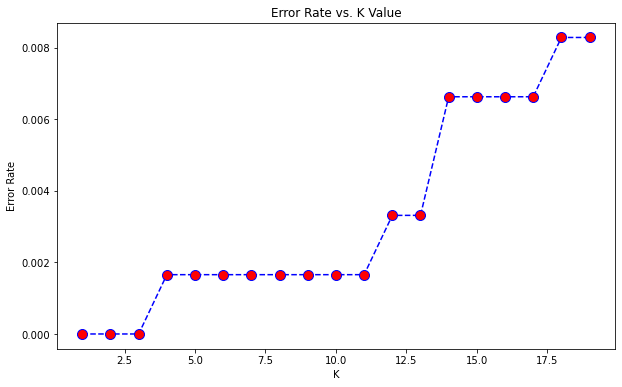

In [31]:
# Optimal K 
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for i in range(1,20):
     knn = KNeighborsClassifier(n_neighbors=i)
     knn.fit(X_train,y_train)
     pred_i = knn.predict(X_test)
     error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

Возьмем "к" как наиближайшее целое к нулю 1. 

In [39]:
# Fitting K-NN to the Training set (4 variables)
knn = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2).fit(X_train, y_train)


In [40]:
# Predicting the Test set results
y_pred1 = knn.predict(X_test)
knn.score(X_test,y_test)

1.0

In [41]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print(cm)

[[579   0]
 [  0  24]]


Модель безошибочно классифицировала объекты.

## Support Vector Machine (SVM)

In [42]:
# Fitting SVM to the Training set (4 variables)
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf', random_state = 10).fit(X_train, y_train)

In [43]:
# Predicting the Test set results
y_pred2 = svm.predict(X_test)
svm.score(X_test,y_test)

0.9983416252072969

In [44]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred2)
print(cm)

[[579   0]
 [  1  23]]


Модель справилась чуть хуже, чем предыдущая и как и логистическая имеет один неправильно определенный объект

## Naive Bayes

In [45]:
# Fitting Naive Bayes to the Training set (4 variables)
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(X_train, y_train)

In [46]:
# Predicting the Test set results
y_pred3 = nb.predict(X_test)
nb.score(X_test,y_test)

0.9933665008291874

In [47]:

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred3)
print(cm)

[[575   4]
 [  0  24]]


Данная модель едиснственная из построенных ранее определила 4 ложно позитивных объекта. Ее точность не самая высокая. 

## Classification Tree

In [48]:
# Function Max Leaf
def max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_leaf_nodes = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")

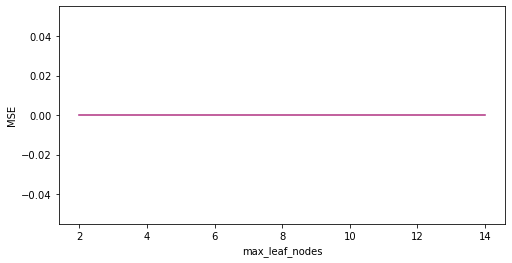

In [63]:
# The optimal number of max_leaf_nodes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
max_leaf_nodes(X_train, X_test, y_train, y_test, [2, 4, 6, 8, 10, 12, 14])

Оптимальное количество ветвлений берем 2. 

In [51]:
# Fitting Classification Tree to the Training set 
from sklearn.tree import DecisionTreeClassifier
ct = DecisionTreeClassifier(max_leaf_nodes = 2, criterion = 'entropy', random_state = 10).fit(X_train, y_train)

In [52]:
# Predicting the Test set results
y_pred4 = ct.predict(X_test)
ct.score(X_test,y_test)

1.0

In [53]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred4)
print(cm)

[[579   0]
 [  0  24]]


Моедль справилась безошибочно. Построим модель случайного леса.

In [54]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestClassifier(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")

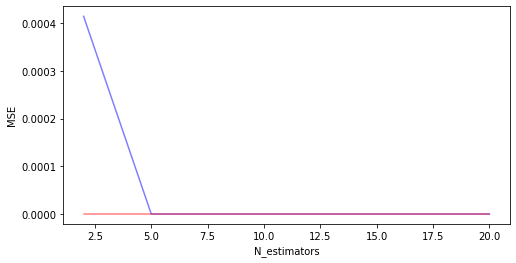

In [55]:
# The optimal number of trees 
from sklearn.ensemble import RandomForestClassifier    
rf_best_n_estimator(X_train, X_test, y_train, y_test, [2, 5, 10, 15, 20])

Количество деревей выберем 5

In [56]:
def rf_max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestClassifier(n_estimators=5, max_leaf_nodes =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")

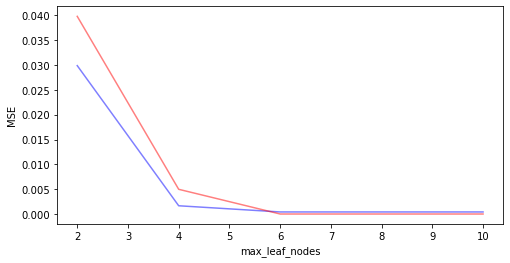

In [57]:

# The optimal number of max_leaf_nodes
rf_max_leaf_nodes(X_train, X_test, y_train, y_test, [2, 4, 6, 8, 10])

Возьмем max_leaf_nodes=6, поскольку при даном значении наблюдается наименьшее значение MSE на тестовой и тренировочной выборках.

In [64]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 5, max_leaf_nodes = 6, random_state = 10).fit(X_train, y_train)

In [65]:

# Predicting the Test set results
y_pred5 = rf.predict(X_test)
y_pred5 = (y_pred5 > 0.5)
rf.score(X_test,y_test)

1.0

In [66]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred5)
print(cm)

[[579   0]
 [  0  24]]


Модель также безошибочно справилась с классификацией. 

In [61]:

# Install Tensorflow
# Install Keras
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

ModuleNotFoundError: No module named 'keras'

In [ ]:
# Initialising the ANN 4-3-1
cnn1 = Sequential()

# Adding the input layer and the first hidden layer
cnn1.add(Dense(output_dim = 3, init = 'uniform', activation = 'relu', input_dim = 4))

# Adding the output layer
cnn1.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting the ANN to the Training set
cnn1.fit(X_train, y_train, batch_size = 10, nb_epoch = 100)

In [ ]:
# Predicting the Test set results
y_pred6 = cnn1.predict(X_test)
y_pred6 = (y_pred6 > 0.5)

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred6)
print(cm1)